In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
from scipy import stats

## A colour list is provided with sufficient and suitable colours for multiple sunburst plots

Colours are RGB values that are bright enough for good readability on the plot

In [2]:
colour_list = [[0.733, 0.467, 0.518], [0.596, 1.0, 0.322], [0.88, 0.66, 0.795], [0.857, 0.524, 0.531], [0.52, 0.508, 0.61], [0.059, 0.812, 0.753], [0.902, 0.686, 0.725], [0.99, 0.99, 0.6], [0.517, 0.778, 0.821], [0.473, 0.778, 0.406], [0.565, 0.984, 0.573], [0.72, 0.1, 0.657], [0.836, 0.977, 0.736], [0.746, 0.835, 0.83], [0.745, 0.6, 0.439], [0.49, 0.529, 0.725], [0.682, 0.537, 0.689], [0.561, 0.993, 0.936], [0.559, 0.367, 0.794], [0.265, 0.425, 0.825], [0.743, 0.241, 0.1], [0.684, 0.1, 0.327], [0.5, 0.8, 0.99], [0.571, 0.61, 0.292], [0.941, 0.725, 0.553], [0.682, 0.537, 0.689], [0.934, 0.558, 0.516], [0.741, 0.827, 0.576], [0.744, 0.932, 0.921], [0.998, 0.969, 0.942], [0.969, 0.612, 0.831], [0.5, 0.8, 0.99], [1.0, 0.1, 0.437], [0.552, 0.863, 0.908], [0.1, 0.492, 0.104], [0.815, 0.768, 0.763], [1.0, 0.576, 0.494], [0.937, 0.592, 0.031], [0.1, 0.782, 0.594], [0.934, 0.558, 0.516], [0.695, 0.541, 0.524], [0.569, 0.816, 0.796], [1.0, 0.859, 0.4], [0.3, 0.4, 0.7], [0.553, 0.835, 0.576], [0.522, 0.584, 0.882], [1.0, 0.898, 0.008], [0.516, 0.61, 0.524]]

### If you change any of the colours in the colourlist, then it can be saved in a json file as well

In [ ]:
with open("colours.json", "w") as outfile:
    json.dump(colour_list, outfile)
print(np.asarray(colour_list))
print("Number of available colours: ", len(colour_list))

### ... and loaded

In [ ]:
with open("colours.json", "r") as infile:
    colour_list = json.load(infile)

## Sunburst function

In [27]:
def sunburst(nodes, dic, total=np.pi * 2, offset=0, level=0, ax=None, text_smaller=False):
    ax = ax or plt.subplot(111, projection='polar')

    if level == 0 and len(nodes) == 1:
        label, value, subnodes = nodes[0]
        ax.bar([0], [0.5], [np.pi *2], color="white")
        ax.text(0, 0, label, ha='center', va='center', fontsize=15)
        if text_smaller:
            sunburst(subnodes, dic, total=value, level=level + 1, ax=ax, text_smaller=True)
        else: 
            sunburst(subnodes, dic, total=value, level=level + 1, ax=ax)
    elif nodes:
        d = np.pi * 2 / total
        labels = []
        widths = []
        local_offset = offset
        for label, value, subnodes in nodes:
            labels.append(label)
            widths.append(value * d)
            # sunburst(subnodes, dic, total=total, offset=local_offset,
              #       level=level + 1, ax=ax)
            if text_smaller:
                sunburst(subnodes, dic, total=total, offset=local_offset,
                     level=level + 1, ax=ax, text_smaller=True)
            else: 
                sunburst(subnodes, dic, total=total, offset=local_offset, level=level + 1, ax=ax)
            local_offset += value
        values = np.cumsum([offset * d] + widths[:-1])
        heights = [1] * len(nodes)
        bottoms = np.zeros(len(nodes)) + level - 0.5

        rects = ax.bar(values, heights, widths, bottoms, linewidth=0,
                       edgecolor='white', align='edge')
   
        for rect, label in zip(rects, labels):
            x = rect.get_x() + rect.get_width() / 2
            y = rect.get_y() + rect.get_height() / 2
            rotation = (90 + (360 - np.degrees(x) % 180)) % 360
            if text_smaller:
                if len(label)>18:
                    name = str(label).split(" ")
                    name.insert(-1,"\n")
                    new_label = " ".join(name)
                else: 
                    new_label = label
            else:
                new_label = label
            ax.text(x, y, new_label, rotation=rotation, ha='center', va='center', fontsize=15)
            try:
                rect.set_color(dic[label])
            except KeyError:
                pass

    if level == 0:
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location('N')
        ax.set_axis_off()
        
def get_data_list(ebene1, ebene2, ebene3=np.array([])):
    group_freq = stats.itemfreq(ebene1)
    data = []
    for i in group_freq:
        inner_list = []
        filtered_ebene2 = ebene2[np.where(ebene1==i[0])]
        for j in stats.itemfreq(filtered_ebene2):
            inner_inner_list = []
            if len(ebene3)>0:
                filtered_ebene3 = ebene3[np.where(ebene1==i[0])]
                for k in stats.itemfreq(filtered_ebene3[np.where(filtered_ebene2==j[0])]):
                    new_name = str(k[0])
                    inner_inner_list.append((new_name, k[1],[]))
            tup = (j[0], int(j[1]), inner_inner_list)
            # print(j[0].replace("\n", ""), "ratio of ", i[0].replace("\n", ""), ":", int(j[1])/float(int(i[1])))
            inner_list.append(tup)
        data.append((i[0],int(i[1]), inner_list))
        # print("\n ratio of ", i[0].replace("\n", ""), ":", int(i[1])/float(len(ebene1)), "\n")
        
    # for j in stats.itemfreq(ebene2):
        # print("\n ratio of ", j[0], ":", int(j[1])/float(len(ebene2)))

    data_final = [("All data", len(ebene1), data)]
    
    # MAKE COLOUR DICTIONARY:
    
    dic = {}
    colour_counter = 0
    for ebene in ["ebene1", "ebene2", "ebene3"]:
        for e in np.unique(eval(ebene)):
            dic[e] = colour_list[colour_counter]
            colour_counter+=1
    
    return dic, data_final

## Load your data here

In [28]:
example_data = pd.read_csv("student/student-por.csv", delimiter=";")
print(example_data)

    school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F   18       U     GT3       A     4     4   at_home   teacher   
1       GP   F   17       U     GT3       T     1     1   at_home     other   
2       GP   F   15       U     LE3       T     1     1   at_home     other   
3       GP   F   15       U     GT3       T     4     2    health  services   
4       GP   F   16       U     GT3       T     3     3     other     other   
5       GP   M   16       U     LE3       T     4     3  services     other   
6       GP   M   16       U     LE3       T     2     2     other     other   
7       GP   F   17       U     GT3       A     4     4     other   teacher   
8       GP   M   15       U     LE3       A     3     2  services     other   
9       GP   M   15       U     GT3       T     3     4     other     other   
10      GP   F   15       U     GT3       T     4     4   teacher    health   
11      GP   F   15       U     GT3       T     2   

### Select columns for each level of the circle plot

In [29]:
first_level = "sex"
second_level = "address"
third_level =  "Mjob"

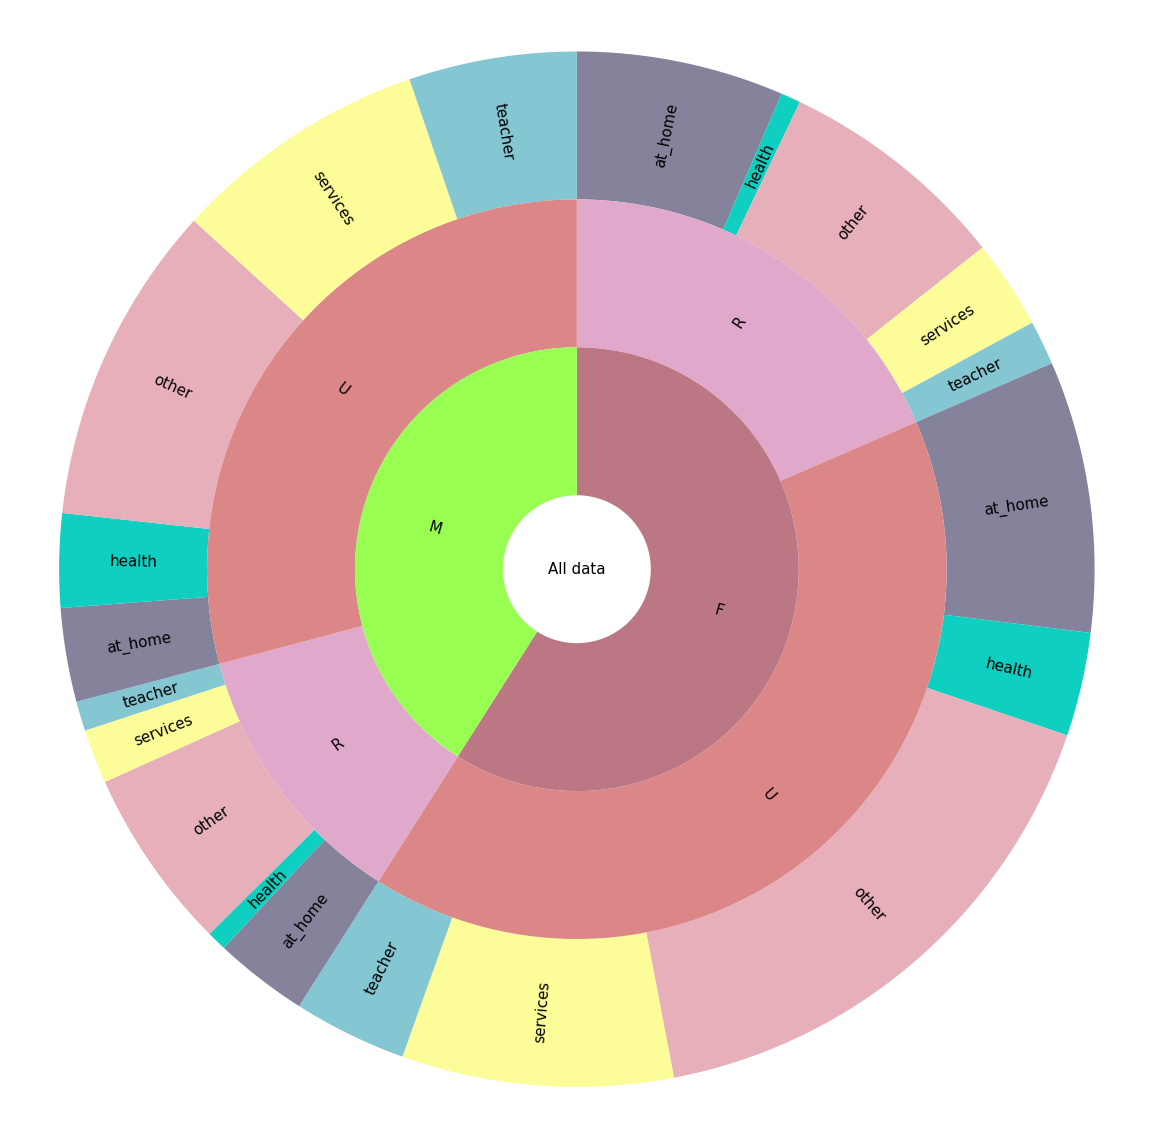

In [30]:
dic, data_sunburst = get_data_list(example_data[first_level].values, example_data[second_level].values, example_data[third_level].values)

plt.figure(figsize = (20,20))
sunburst(data_sunburst, dic)
plt.show()